**I import some useful libraries in python.**

In [ ]:
import difflib
import operator as op
import random
import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup
import os
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import BertModel
from transformers import BertTokenizerFast

**I mount google drive because all the files (for example .csv) that i used for the implementation of my thesis are saved on my google drive.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Check of the device that it is used for the implementation of the notebooks of this thesis, that is determined from google colab.**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available for running: ")
print(device)

Device available for running: 
cuda


**Reading of the created datasets (for both the SimpleQuestions dataset that includes all training and validation questions and the SimpleQuestions subset that includes only answerable over wikidata questions) as .csv file.**

In [ ]:
train_dataset = pd.read_csv("drive/MyDrive/train_dataset.csv", sep = ',')
validation_dataset = pd.read_csv("drive/MyDrive/valid_dataset.csv", sep = ',')
print(train_dataset)
print(validation_dataset)

       entity_id      entity_label relation_id  \
0        Q126399       Warner Bros        R272   
1         Q12439           Detroit         R19   
2       Q7370831          Q7370831        P162   
3       Q6817891       Mera Shikar        P364   
4          Q1297           Chicago        R276   
...          ...               ...         ...   
34369  Q16093542    Anthony Bailey         P27   
34370    Q325741     Homi K Bhabha        P737   
34371   Q1062702  video game music        R136   
34372    Q926822  Gaston Filgueira         P21   
34373    Q336286          defender        R413   

                                                Question  
0                  what movie is produced by warner bros  
1                      who is a musician born in detroit  
2                who produced the film rough house rosie  
3      what is the language in which mera shikar was ...  
4      Whats the name of a battle that happened in ch...  
...                                          

**Check if  the SimpleQuestions training and validation dataset have at least one line with null value. This issues both for SimpleQuestions dataset that includes only answerable over wikidata questions and for the corresponding dataset that includes all the questions.**

In [ ]:
train_dataset.dropna(inplace = True)
validation_dataset.dropna(inplace = True)
print(train_dataset)
print(validation_dataset)

       entity_id      entity_label relation_id  \
0        Q126399       Warner Bros        R272   
1         Q12439           Detroit         R19   
2       Q7370831          Q7370831        P162   
3       Q6817891       Mera Shikar        P364   
4          Q1297           Chicago        R276   
...          ...               ...         ...   
34369  Q16093542    Anthony Bailey         P27   
34370    Q325741     Homi K Bhabha        P737   
34371   Q1062702  video game music        R136   
34372    Q926822  Gaston Filgueira         P21   
34373    Q336286          defender        R413   

                                                Question  
0                  what movie is produced by warner bros  
1                      who is a musician born in detroit  
2                who produced the film rough house rosie  
3      what is the language in which mera shikar was ...  
4      Whats the name of a battle that happened in ch...  
...                                          

**Creation of the corresponding lists containing the questions, the entity labels, the relation ids and the entity ids of the corresponding SimpleQuestions datasets (training, validation), either this dataset includes answerable and answerable questions over wikidata questions or only answerable questions over wikidata.**

In [ ]:
train_entity_labels = train_dataset['entity_label'].to_list()
validation_entity_labels = validation_dataset['entity_label'].to_list()
train_entityids = train_dataset['entity_id'].to_list()
validation_entityids = validation_dataset['entity_id'].to_list()
train_questions = train_dataset['Question'].to_list()
validation_questions = validation_dataset['Question'].to_list()
train_relationids = train_dataset['relation_id'].to_list()
validation_relationids = validation_dataset['relation_id'].to_list()
print(len(train_entity_labels), len(train_entityids), len(train_relationids), len(train_questions))

34373 34373 34373 34373


**The maximum question length that is observed in SimpleQuestions training and validation dataset is found below.**

In [ ]:
#Below the max questions length is found for all questions.
quests = train_questions + validation_questions
print(len(quests), len(train_questions), len(validation_questions))
# Printing concatenated list
q_lengths = []
for s in range(len(quests)): #padding
    q_lengths.append(len(quests[s].split()))
max_question_length = max(q_lengths)
print(max_question_length)#Max question length

39240 34373 4867
33


**Creation of the relation vocabulary that includes all the unique entity ids of the SimpleQuestions training and validation dataset through function relation_vocabulary. Also the index of each unique relation id of the relation vocabulary in this vocabulary is found through the function find_relations_index.**

In [ ]:
#Create relation vocabulary for each question of train and validation dataset
def relation_vocabulary(relation_column_dataset):
  relation_vocabulary = []
   #In order to have the unique relation ids it is important to check if an relation id is already in the relation_vocabulary
  for relation in range(len(relation_column_dataset)):
    g = 0
    for i in range(len(relation_vocabulary)):
      if relation_column_dataset[relation] != relation_vocabulary[i]: #relation is not found yet
        g += 1
      else:
       continue
    if g == len(relation_vocabulary) and relation_column_dataset[relation] not in relation_vocabulary:
      relation_vocabulary.append(relation_column_dataset[relation]) #The relation id is not inside the relation vocabulary
      #which has some relations already or the relation vocaulary has no relations
  return relation_vocabulary

def find_relation_index(relation_vocabulary,relation_ids_column):
  relations_count = []
  for relation in range(len(relation_ids_column)):
        relations_count.append(relation_vocabulary.index(relation_ids_column[relation]))

  return relations_count
#relation_ids = pd.concat([train_dataset["relation_id"], validation_dataset["relation_id"]], ignore_index = True)
relation_ids = train_relationids + validation_relationids
print(len(relation_ids))
rel_vocab = relation_vocabulary(relation_ids)
rel_vocab_length = len(rel_vocab)
print(rel_vocab, rel_vocab_length)
train_relations_index = find_relation_index(rel_vocab, train_relationids)
validation_relations_index = find_relation_index(rel_vocab, validation_relationids)

39240
['R272', 'R19', 'P162', 'P364', 'R276', 'R413', 'R607', 'P413', 'R136', 'P27', 'P21', 'P136', 'P738', 'R106', 'P196', 'P175', 'R175', 'R50', 'P344', 'P641', 'P19', 'P421', 'R421', 'R57', 'P170', 'R17', 'P287', 'P86', 'R58', 'R86', 'P1142', 'P20', 'P58', 'P264', 'P131', 'P106', 'P172', 'P495', 'P150', 'R131', 'R509', 'P119', 'R1303', 'P50', 'R40', 'P1303', 'P61', 'R172', 'P57', 'P140', 'P179', 'R344', 'P1040', 'P509', 'P138', 'P397', 'P407', 'P398', 'P272', 'R264', 'P403', 'P31', 'P607', 'R287', 'R162', 'R641', 'R404', 'P1408', 'R178', 'R279', 'P123', 'P59', 'P40', 'P276', 'P1431', 'P178', 'P737', 'R179', 'P17', 'P171', 'R170', 'P144', 'P112', 'R105', 'R676', 'R59', 'P113', 'P155', 'P289', 'R149', 'P404', 'P710', 'P676', 'P149', 'R1040', 'R177', 'R119', 'P279', 'R21', 'R112', 'R31', 'R138', 'P53', 'R123', 'P65', 'P156', 'P177', 'R144', 'R1431', 'P81', 'P115', 'P105', 'P800', 'R171', 'P1029', 'R115', 'P84', 'R1142', 'P376', 'R376', 'P1308', 'P826', 'R161', 'R289', 'R176', 'P189', '

**The function create\_question\_parts, takes as arguments the splitted question splitted into words and the entity label also splitted into words.
Essentially in this function each question, as well as the corresponding entity label, is splitted into words using python method split() and then, using python method join(), parts of the query are created equal in length to that of their splitted entity label in words.**

**These parts are stored in a list as well as the indexes of the initial word and final word of these question parts are stored in dictionaries with keys the question parts and values the indexes(positions) of the initial words and final words for each question. Finally this function returns the list of question parts and dictionaries containing the indexes(positions) of the initial words and final words for each question part.**

In [ ]:
#The fact that the corresponding question part start index is lower to
#the corresponding question part start index is lower is an indirect efficient way to ensure that all ones that are added in this span are successive.
#That it is very helpful to find entity span start index and entity span end index later.
def create_question_parts(question_splitted, entity_splited_length):
  Quests_Parts = []
  Quest_Parts_Start = {}
  Quest_Parts_End = {}
  for i in range(len(question_splitted)-entity_splited_length+1):
    quest_part = " ".join(question_splitted[i:i+entity_splited_length])
    Quests_Parts.append(quest_part)
    Quest_Parts_Start[quest_part] = i
    Quest_Parts_End[quest_part] = i+entity_splited_length-1
  return Quests_Parts, Quest_Parts_Start, Quest_Parts_End

**Through the create_entity_span function below that takes as arguments the question splitted in words and the indexes of the initial and final word of the part of the question that is equal to the corresponding entity label, the entity span for each question is created.**

**In this entity span because the words that make up the entity label must be in consecutive positions within the question, it is always necessary that when creating the entity span, the index specifying the position of the starting word of the equal question part with the corresponding entity label for the question must be less than or equal to the corresponding index of the ending word of that equal question part. This indirectly ensures that the ones that enter the entity span are consecutive and equal in number to the length of the entity label splitted in words. This function returns the entity span, as well as the number of consecutive ones in it for each question.**

In [ ]:
#Create entity span
def create_entity_span(question_splitted_length, quest_part_start, quest_part_end):
   entity_span = []
   count_successive_ones = 0
   for k in range(question_splitted_length):
     if k >= quest_part_start and k <= quest_part_end:
        entity_span.append(1)
        count_successive_ones += 1
     else:
        entity_span.append(0)

   return entity_span, count_successive_ones

**Through the find_start_and_end_index function, which takes as arguments the entity span, the entity label, the list of all the parts of the question, the dictionaries with keys the parts for each question and values the indexes of the start words and end words for each question, the length of the question and the number of consecutive ones of the entity span which are counted in this function, the question part that is equal with the entity label, the position of the initial word (index of the first one in the entity span) of the entity label and respectively the position of the final word (index of the last one in the entity span) could be found. If the entity span that is created for a question is not full of zeros, then a logical variable is used to confirm that all ones present are contiguous.**

**In the case, of course, that no word of the entity label is present in the words of the corresponding question, the entity span will consist only of zeros, so there is no word to derive the corresponding indices for entity start and entity end. So each question with an entity span full of zeros is ignored from the training and validation process.**

In [ ]:
#Create for each question the entity span and find the entity span start index and the entity span end index.
def find_start_and_end_index(entity_label, entity_label_splitted_length, question_parts, question_splitted_length, start_indexes, end_indexes):
  entity_span_start_index = -1
  entity_span_end_index = -1
  quest_part_start_index = -1
  quest_part_end_index = -1
  entity_span = []
  entity_span_with_successive_ones = 0
  for q_p in range(len(question_parts)):
    if question_parts[q_p] == entity_label:
      quest_part = question_parts[q_p]
      quest_part_start_index = start_indexes[quest_part]
      quest_part_end_index = end_indexes[quest_part]
  entity_span, count_successive_ones = create_entity_span(question_splitted_length, quest_part_start_index, quest_part_end_index)
  if entity_span != [0]*question_splitted_length:
   entity_span_with_successive_ones = 1
   entity_span_start_index = entity_span.index(1)
   entity_span_end_index = entity_span_start_index + count_successive_ones-1
  return entity_span, entity_span_with_successive_ones, entity_span_start_index, entity_span_end_index

**The entity_span_encoded function takes as arguments the list of all questions of the given SimpleQuestions dataset (training or validation), the list of all entity labels of the SimpleQuestions dataset (training or validation) and returns the list of entity spans, as well as the lists of start and end position indices for each entity label for all questions. It is worth noting that this function counts the number of questions whose entity span consists of 0 and 1, where the ones are contiguous. Also these questions are inserted into lists all these questions as well as their corresponding entity labels, entity spans, entity span start indexes, entity span end indexes and relation ids.**

In [ ]:
#Create entity span by create an list which consists of zeros and ones. By checking in which part for each question the correspoding entity
#exists and in these indexes of the span to replace with ones.
#This is applied for each one of the train and validation questions
def entity_span_encoded(question_column_dataset, entity_label_column_dataset, relation_indexes):
  span_start_index = []
  span_end_index = []
  relations_index_list = []
  entity_spans = []
  entity_labels_list = []
  questions_list = []
  count_spans_with_successive_ones = 0
  for q in range(len(question_column_dataset)):
      quest = question_column_dataset[q].lower().split()
      quest_splitted_length  = len(quest)
      ent_label = entity_label_column_dataset[q].lower()
      s = ent_label.split()
      entity_label_splitted_length = len(s)
      Quests_Parts, Quest_Parts_Start, Quest_Parts_End = create_question_parts(quest, entity_label_splitted_length)
      entity_span, span_with_successive_ones, entity_span_start_index, entity_span_end_index = find_start_and_end_index(ent_label, entity_label_splitted_length, Quests_Parts, quest_splitted_length, Quest_Parts_Start, Quest_Parts_End)
      if span_with_successive_ones == 1:#Boolean variable
        span_start_index.append(entity_span_start_index)
        span_end_index.append(entity_span_end_index)
        relations_index_list.append(relation_indexes[q])
        entity_spans.append(entity_span)
        questions_list.append(question_column_dataset[q])
        entity_labels_list.append(entity_label_column_dataset[q])
        count_spans_with_successive_ones += 1
  print(count_spans_with_successive_ones)
  return entity_spans, span_start_index, span_end_index, relations_index_list, questions_list, entity_labels_list

train_span, train_entity_span_encoded_start_indexes, train_entity_span_encoded_end_indexes, train_entity_span_encoded_relations_list, train_entity_span_encoded_questions_list, train_span_encoded_entity_labels_list = entity_span_encoded(train_questions, train_entity_labels, train_relations_index)
validation_span, validation_entity_span_encoded_start_indexes, validation_entity_span_encoded_end_indexes, validation_entity_span_encoded_relations_list, validation_entity_span_encoded_questions_list, validation_span_encoded_entity_labels_list = entity_span_encoded(validation_questions, validation_entity_labels, validation_relations_index)
print(train_span[13174])
print(train_entity_span_encoded_questions_list[13174])
print(train_span_encoded_entity_labels_list[13174])
print(train_span[2])
print(train_entity_span_encoded_questions_list[2])
print(validation_span[3])
print(validation_entity_span_encoded_questions_list[3])
print(validation_span_encoded_entity_labels_list[3])
print(train_span[230], train_entity_span_encoded_questions_list[230], train_span_encoded_entity_labels_list[230])


31046
4429
[0, 0, 1, 1, 0]
whois an experimental music artist
experimental music
[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
what is the language in which mera shikar was filmed in
[0, 0, 0, 0, 0, 1, 1, 1, 0]
in what french city did antoine de fevin die 
Antoine de Fevin
[0, 0, 0, 0, 0, 1, 1, 0, 0] What is a South Korean romance film from 2011 romance film


**Loading of the Transformers BERT tokenizer BertTokenizerFast.**

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

**Creation of a custom dataset for the SimpleQuestions dataset (either for the dataset with only answerable over wikidata questions or for the corresponding dataset including answerable and non-answerable over wikidata questions) through a python class, where its questions are encoded through BertTokenizerFast method encode\_plus(). This custom dataset includes the entity span indexes (start, end), the relation indexes, the questions, the ids and the attention mask occurred from encoding of questions.**

**Also since the span start and end correspond to actual words, but here I use the fast version of BERT tokenizer BertTokenizerFast, i need to locate the corresponding start and end tokens in the BERT tokenized question for each entity.**

**Also in order to create this custom dataset i used the lists of questions, relation, entity span start, entity span end indexes, the maximum question length of all SimpleQuestions training and validation dataset questions.**

In [ ]:
g = torch.Generator()
print(g.device)

cpu


In [ ]:
class BertQuestionAnsweringDataset:
  def __init__(self, questions, tokenizer, entity_starts, entity_ends, relation_indexes, length, generator, shuffle=True):
        self.questions = questions
        self.max_length = length
        self.tokenizer = tokenizer
        self.relation_indexes = relation_indexes
        self.g = generator
        self.shuffle = shuffle
        ids = []
        masks = []
        start_ent = []
        end_ent = []
        # Encode questions
        for question in range(len(self.questions)):
          encoding = self.tokenizer.encode_plus(
             text = self.questions[question],
             max_length=self.max_length,
             truncation=True,
             pad_to_max_length=True,
             return_attention_mask=True,
             padding='max_length',
             add_special_tokens=False
          )
          Question = self.questions[question].split()
          # Locate the corresponding start in the BERT tokenized question
          start_token = tokenizer.encode_plus(
            text = Question[entity_starts[question]],
            return_attention_mask=True,
            add_special_tokens=False
        )
          # Locate the corresponding end in the BERT tokenized question
          end_token = tokenizer.encode_plus(
            text = Question[entity_ends[question]],
            return_attention_mask=True,
            add_special_tokens=False
        )
          ids.append(encoding['input_ids'])
          masks.append(encoding['attention_mask'])
          start_ent.append(encoding['input_ids'].index(start_token['input_ids'][0]))
          end_ent.append(encoding['input_ids'].index(end_token['input_ids'][-1]))
        self.input_ids = ids
        self.attention_masks = masks
        self.entity_start_indexes = start_ent
        self.entity_end_indexes = end_ent

  def __len__(self):
        return len(self.questions)

  def __getitem__(self, idx):
        return { 'input_ids': torch.tensor(self.input_ids[idx]),
                'attention_mask':  torch.tensor(self.attention_masks[idx]),
                'relation_indexes': torch.tensor(self.relation_indexes[idx]),
                'entity_start': torch.tensor(self.entity_start_indexes[idx], dtype = torch.long),
                'entity_end': torch.tensor(self.entity_end_indexes[idx], dtype = torch.long)
               }

  def set_epoch(self, epoch):
      self.epoch = epoch
      if self.shuffle:
         self.g.manual_seed(123456789 + self.epoch)





**In the above custom dataset class i reseed the workers using worker\_init\_fn() to preserve reproducibility through by creating the following function seed\_worker.**

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

**Creation of the dataloader through the created custom dataset from pytorch for the training and validation dataset of SimpleQuestions dataset. The batch size is equal to 32.**

In [ ]:
#span_encoded is reffering to the 2nd way of finding entity start and entity end indexes, i.e entity span encoded with 0 and 1.
print(len(train_entity_span_encoded_questions_list), len(train_entity_span_encoded_start_indexes), len(train_entity_span_encoded_end_indexes), len(train_entity_span_encoded_relations_list))
train_span_encoded_bert_dataset = BertQuestionAnsweringDataset(train_entity_span_encoded_questions_list, tokenizer, train_entity_span_encoded_start_indexes, train_entity_span_encoded_end_indexes, train_entity_span_encoded_relations_list, max(q_lengths), g)
valid_span_encoded_bert_dataset = BertQuestionAnsweringDataset(validation_entity_span_encoded_questions_list, tokenizer ,validation_entity_span_encoded_start_indexes, validation_entity_span_encoded_end_indexes, validation_entity_span_encoded_relations_list, max(q_lengths), g)
train_dataloader_span_encoded = torch.utils.data.DataLoader(train_span_encoded_bert_dataset, batch_size=32, num_workers = 0, worker_init_fn=seed_worker, shuffle=True, generator = train_span_encoded_bert_dataset.g)
val_dataloader_span_encoded = torch.utils.data.DataLoader(valid_span_encoded_bert_dataset, batch_size=32, num_workers = 0, worker_init_fn=seed_worker, shuffle=True, generator = valid_span_encoded_bert_dataset.g)

31046 31046 31046 31046


**Function that contributes to the preservation of the reproducibility.**

In [ ]:
#To preserve reproducibility
SEED = 42
def set_seed(SEED):
 random.seed(SEED)# Set python seed for custom operators.
 torch.manual_seed(SEED)
 np.random.seed(SEED)
 torch.cuda.manual_seed_all(SEED)
 torch.backends.cudnn.benchmark = False
 torch.backends.cudnn.deterministic = True

**Through the create\_file function, is created a file in .pt, in which the parameters for each model are stored. This function takes as an argument a name for the folder where the model will be saved (e.g. "drive/MyDrive/") and a name for the name of the file where each model is saved (e.g. "relation\_prediction.pt").**

In [ ]:
def create_file(model_dir, model_save_name):
 if not os.path.exists(model_dir):
    os.makedirs(model_dir)
 model_save_path = os.path.join(model_dir, model_save_name)
 return model_save_path

****Construction and initialization of the neural network for the prediction of the relation for each question.****

In [ ]:
class BertRelationsClassifier(nn.Module):
  def __init__(self, activation, dropout_prob, rel_vocab_len):
    super(BertRelationsClassifier, self).__init__()
    activations = {
        "ELU" : nn.ELU,
        "LeakyReLU"    : nn.LeakyReLU,
        "Softplus"     : nn.Softplus,
        "Tanhshrink"     : nn.Tanhshrink
 }
    self.bert_model = BertModel.from_pretrained('bert-base-uncased')
    self.rel_vocab_len = rel_vocab_len
    self.fc = nn.Linear(768, self.rel_vocab_len)
    self.activation_type = activation
    self.dropout_probability = dropout_prob
    self.activation = activations[self.activation_type]()
    self.dropout = nn.Dropout(self.dropout_probability)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_ids, attention_mask):
        out = self.bert_model(input_ids, attention_mask)
        out = self.fc(out[1])#CLS token-pooled output
        out = self.activation(out)
        out = self.dropout(out)
        out = self.softmax(out)
        return out

**Through the function named relation_prediction_function the best possible parameters for the best possible prediction of the relation are found. This function has as arguments the training dataloader, the validation dataloader, the number of epochs, the optimizer, the scheduler, the learning rate, the relation prediction neural network, entity span prediction) model, the loss function and the dropout probability value.**

**This function returns the best possible model, the list including numbers from 0 to number of training epochs-1, the lists including the values of training losses and validation losses for all epochs respectively and the largest value of f1.**

**The length of the relation vocabulary in the case of training and validating the full SimpleQuestions dataset is equal to 129 and the length of the relation vocabulary for the case of training and validating the SimpleQuestions subset that includes only questions that are answerable over wikidata is equal to 125.
So the predicted relation index as a number must be either between 0 and 128 or between 0 and 124, where this number correspond to the position of the unique relation ids in the corresponding relation vocabulary.**

In [ ]:
def relation_prediction_function(train_dataset, valid_dataset, train_dataloader, val_dataloader, model, loss_func, optimizer, scheduler, epochs, activation, lr, dropout_prob):
 list_loss_train = []
 list_epochs = []
 list_loss = []
 the_last_f1_score = 0
 patience = 3
 max_f1 = -1
 trigger_times = 0
 for epoch in range(epochs):
   train_dataset.set_epoch(epoch)
   valid_dataset.set_epoch(epoch)
   model.train()
   batch_losses = []
   for batch in train_dataloader:
    ids = batch['input_ids'].to(device)
    attention_masks = batch['attention_mask'].to(device)
    relation_indexes = batch['relation_indexes'].to(device)
    y_pred = model(ids, attention_masks)
    loss = loss_func(y_pred.cpu(),relation_indexes.cpu())
    batch_losses.append(loss.detach().numpy())
    #Delete previously stored gradients
    optimizer.zero_grad()

    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 0.7)
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    scheduler.step()
   print(f"Epoch {epoch:3}: Train Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
   list_loss_train.append(sum(batch_losses)/len(train_dataloader))
   with torch.no_grad():
     model.eval()
     F1 = []
     precision = []
     recall = []
     accuracy = []
     batch_losses_val = []
     for batch in val_dataloader:
       ids = batch['input_ids'].to(device)
       attention_masks = batch['attention_mask'].to(device)
       relation_indexes = batch['relation_indexes'].to(device)
       y_predict = model(ids, attention_masks)
       val_loss = loss_func(y_predict.cpu(),relation_indexes.cpu())
       batch_losses_val.append(val_loss)
       y_pr = torch.argmax(y_predict, dim=1).squeeze()
       Y_p = y_pr.tolist()
       y_val = relation_indexes.tolist()
       F1.append(f1_score(y_val, Y_p, average = 'micro'))
       precision.append(precision_score(y_val, Y_p, average = 'micro'))
       recall.append(recall_score(y_val, Y_p, average = 'micro'))
       accuracy.append(accuracy_score(y_val,Y_p))
     Valid_f1 = sum(F1)/len(val_dataloader)
     Valid_accuracy = sum(accuracy)/len(val_dataloader)
     print(f"Epoch {epoch:3}: Valid Loss = {sum(batch_losses_val)/len(val_dataloader):.5f}")
     print(f"Epoch {epoch:3}: Valid f1_score = {Valid_f1:.5f}")
     print(f"Epoch {epoch:3}: Valid Acurracy = {Valid_accuracy:.5f}")
     print(f"Epoch {epoch:3}: Valid Recall score = {sum(recall)/len(val_dataloader):.5f}")
     print(f"Epoch {epoch:3}: Valid Precision score = {sum(precision)/len(val_dataloader):.5f}")
     list_loss.append(sum(batch_losses_val)/len(val_dataloader))
     list_epochs.append(epoch)
     if Valid_f1 > max_f1:
       max_f1 = Valid_f1
       best_model = model
       print('The current f1 score:', Valid_f1)
     if Valid_f1 < the_last_f1_score:
       trigger_times += 1
       print('trigger times:', trigger_times)
       if trigger_times >= patience:
         print('Early stopping!\nStart to test process.')
         break;
     the_last_f1_score = Valid_f1
 return max_f1, list_loss_train, list_loss, list_epochs, best_model

**The function named get_relation_results finds results for the neural networks concerning the relation index and the entity span indexes (start,end). These functions have as arguments the corresponding training dataloader, the corresponding validation dataloader, the number of epochs ,the optimizer, the scheduler get_linear_schedule_with_warmup, the corresponding relation prediction neural network model, the loss function, the learning rate and the SEED number.**

**This function returns the list of training losses, the list of validation losses, and the list of how many epochs each model with each activation function needs to be fully trained.**

In [ ]:
learning_rate  = 2e-5
dropout_prob = 0.3
epochs = 20
list_relation_training_losses = []
list_relation_validation_losses = []
list_relation_epochs = []
loss_func = nn.CrossEntropyLoss()
optimizer_name = "Adam"
def get_relation_results(activation, rel_vocab_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_dataset, valid_dataset, train_dataloader, val_dataloader, SEED):
 set_seed(SEED)
 model = BertRelationsClassifier(activation, dropout_prob, rel_vocab_length).to(device)
 print(model)
 loss_func = loss_func.to(device)
 optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
 scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*epochs)
 f1, list_loss_train, list_loss_valid, list_epochs, best_relation_model = relation_prediction_function(train_dataset, valid_dataset, train_dataloader, val_dataloader, model, loss_func, optimizer, scheduler, epochs, activation, learning_rate, dropout_prob)
 print(f1)
 torch.save(best_relation_model.state_dict(), create_file(f"drive/MyDrive/Relation_indexes_models_best_parameters/All_Questions/{activation}", f"relation_prediction_span_encoded_ignoring_questions_{activation}.pt") )
 print(f"The best parameters are saved for the activation function: {activation}")
 return list_loss_train, list_loss_valid, list_epochs

In [ ]:
list_relation_loss_train_leakyrelu, list_relation_loss_valid_leakyrelu, list_epochs_leakyrelu = get_relation_results("LeakyReLU", rel_vocab_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertRelationsClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
list_relation_loss_train_leakyrelu, list_relation_loss_valid_leakyrelu, list_epochs_leakyrelu = get_relation_results("LeakyReLU", rel_vocab_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertRelationsClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
list_relation_loss_train_tanhshrink, list_relation_loss_valid_tanhshrink, list_epochs_tanhshrink = get_relation_results("Tanhshrink", rel_vocab_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertRelationsClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
list_relation_loss_train_elu, list_relation_loss_valid_elu, list_epochs_elu = get_relation_results("ELU", rel_vocab_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertRelationsClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
list_relation_loss_train_softplus, list_relation_loss_valid_softplus, list_epochs_softplus = get_relation_results("Softplus", rel_vocab_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertRelationsClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
list_relation_training_losses.append(list_relation_loss_train_leakyrelu)
list_relation_validation_losses.append(list_relation_loss_valid_leakyrelu)
list_relation_epochs.append(list_epochs_leakyrelu)
list_relation_training_losses.append(list_relation_loss_train_tanhshrink)
list_relation_validation_losses.append(list_relation_loss_valid_tanhshrink)
list_relation_epochs.append(list_epochs_tanhshrink)
list_relation_training_losses.append(list_relation_loss_train_softplus)
list_relation_validation_losses.append(list_relation_loss_valid_softplus)
list_relation_epochs.append(list_epochs_softplus)
list_relation_training_losses.append(list_relation_loss_train_elu)
list_relation_validation_losses.append(list_relation_loss_valid_elu)
list_relation_epochs.append(list_epochs_elu)

**Through the function plot_losses the learning curves for losses (relation prediction losses, entity span prediction losses) are plotted.**

In [ ]:
def plot_losses(list_epochs, list_training_losses, list_validation_losses, activations, lr, dropout_prob):
 for activation in range(len(activations)):
  plt.plot(list_epochs[activation], list_training_losses[activation], label = f"{activations[activation]},{lr},{dropout_prob}-Training")
  plt.plot(list_epochs[activation], list_validation_losses[activation], label = f"{activations[activation]},{lr},{dropout_prob}-Validation")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 'small')
  plt.xlabel('Number of epochs')
  plt.ylabel('Loss')
  plt.title("loss-score")
  plt.ylim(ymin = 3.5)
activations = ['LeakyReLU','Tanhshrink', 'Softplus','ELU']

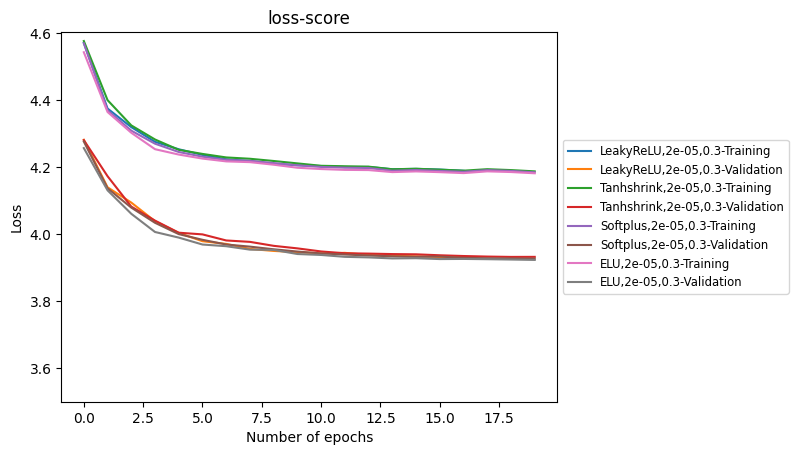

In [ ]:
plot_losses(list_relation_epochs, list_relation_training_losses, list_relation_validation_losses, activations, learning_rate, dropout_prob)

****Construction and initialization of the neural network for the prediction of the entity span start and entity span end indexes for each question.****

In [ ]:
class BertEntitySpanClassifier(nn.Module):
  def __init__(self, activation, dropout_prob, max_quest_len):
    super(BertEntitySpanClassifier, self).__init__()
    self.bert_model = BertModel.from_pretrained('bert-base-uncased')
# Whether the model returns all hidden-states.
    activations = {
        "ELU" : nn.ELU,
        "LeakyReLU"    : nn.LeakyReLU,
        "Softplus"     : nn.Softplus,
        "Tanhshrink"     : nn.Tanhshrink
 }
    self.activation_type = activation
    self.activation = activations[self.activation_type]()
    self.max_length = max_quest_len
    self.dropout_probability = dropout_prob
    self.start_head = nn.Sequential(
          nn.Linear(768, self.max_length),
          self.activation,
          nn.Dropout(p=self.dropout_probability),
          nn.Flatten(),
          nn.Softmax(dim=1)
    )

    self.end_head = nn.Sequential(
          nn.Linear(768, self.max_length),
          self.activation,
          nn.Dropout(p=self.dropout_probability),
          nn.Flatten(),
          nn.Softmax(dim=1)
    )

  def forward(self, input_ids, att_mask):
    out = self.bert_model(input_ids, att_mask)
    out = out[0]
    out_start = self.start_head(out)
    out_end = self.end_head(out)
    return out_start , out_end

**Through the function named entity_prediction_function the best possible parameters for the best possible prediction of the entity span are found. This function has as arguments the corresponding training dataloader, the corresponding validation dataloader, the number of epochs, the optimizer, the scheduler, the learning rate, the entity span prediction neural network model, the loss function and the dropout probability value.**

**This function returns the best possible model, the list including numbers from 0 to number of training epochs-1, the lists including the values of training losses and validation losses for all epochs respectively, the largest value of f1 for entity span start and the largest value of f1 for entity span end.**

**The biggest length of a question in words that is observed in SimpleQuestions dataset is equal to 33. Thus these predicted indexes as numbers must be either between 0 and 32, where these numbers correspond to the position of these words in their question for each question.**

In [ ]:
def entity_prediction_function(train_dataset, valid_dataset, train_dataloader, val_dataloader, model, loss_func, optimizer, scheduler, epochs, activation, lr, dropout_prob):
 list_loss_train = []
 list_loss = []
 list_epochs = []
 the_last_f1_start_score = 0
 the_last_f1_end_score = 0
 patience = 3
 max_f1_start = -1
 max_f1_end = -1
 trigger_times = 0
 for epoch in range(epochs):
  train_dataset.set_epoch(epoch)
  valid_dataset.set_epoch(epoch)
  model.train()
  batch_losses = []
  for batch in train_dataloader:
   input_ids = batch['input_ids'].to(device)
   attention_masks = batch['attention_mask'].to(device)
   entity_span_start_indexes = batch['entity_start'].to(device)
   entity_span_end_indexes = batch['entity_end'].to(device)
   y_pred_start, y_pred_end = model(input_ids, attention_masks)
   y_pred_start = y_pred_start.squeeze()
   y_pred_end = y_pred_end.squeeze()
   start_preds = torch.argmax(y_pred_start,dim = 1)
   loss = loss_func(y_pred_start.cpu(),entity_span_start_indexes.cpu())+loss_func(y_pred_end.cpu(),entity_span_end_indexes.cpu())
   batch_losses.append(loss.detach().numpy())
    #Delete previously stored gradients
   nn.utils.clip_grad_norm_(model.parameters(), 0.7)
   optimizer.zero_grad()

    #Perform backpropagation starting from the loss calculated in this epoch
   loss.backward()

    #Update model's weights based on the gradients calculated during backprop
   optimizer.step()
   scheduler.step()
  print(f"Epoch {epoch:3}: Train Loss = {sum(batch_losses)/len(train_dataloader):.5f}")
  list_loss_train.append(sum(batch_losses)/len(train_dataloader))
  with torch.no_grad():
    model.eval()
    F1_start = []
    F1_end = []
    accuracy_start = []
    accuracy_end = []
    precision_start = []
    precision_end = []
    recall_start = []
    recall_end = []
    batch_losses_val = []
    for batch in val_dataloader:
      input_ids = batch['input_ids'].to(device)
      attention_masks = batch['attention_mask'].to(device)
      entity_span_start_indexes = batch['entity_start'].to(device)
      entity_span_end_indexes = batch['entity_end'].to(device)
      y_predict_start, y_predict_end = model(input_ids, attention_masks)
      y_predict_start = y_predict_start.squeeze()
      y_predict_end = y_predict_end.squeeze()
      val_loss = loss_func(y_predict_start.cpu(),entity_span_start_indexes.cpu())+loss_func(y_predict_end.cpu(),entity_span_end_indexes.cpu())
      batch_losses_val.append(val_loss)
      y_pr_start = torch.argmax(y_predict_start, dim=1)
      y_pr_end = torch.argmax(y_predict_end, dim=1)
      Y_p_start = y_pr_start.tolist()
      Y_p_end = y_pr_end.tolist()
      y_val_start = entity_span_start_indexes.tolist()
      y_val_end = entity_span_end_indexes.tolist()
      F1_start.append(f1_score(y_val_start, Y_p_start, average = 'micro'))
      F1_end.append(f1_score(y_val_end, Y_p_end, average = 'micro'))
      accuracy_start.append(accuracy_score(y_val_start, Y_p_start))
      accuracy_end.append(accuracy_score(y_val_end, Y_p_end))
      precision_start.append(precision_score(y_val_start, Y_p_start, average = 'micro'))
      precision_end.append(precision_score(y_val_end, Y_p_end, average = 'micro'))
      recall_start.append(recall_score(y_val_start, Y_p_start, average = 'micro'))
      recall_end.append(recall_score(y_val_end, Y_p_end, average = 'micro'))
    Valid_f1_start = sum(F1_start)/len(val_dataloader)
    Valid_f1_end = sum(F1_end)/len(val_dataloader)
    print(f"Epoch {epoch:3}: Valid Loss = {sum(batch_losses_val)/len(val_dataloader):.5f}")
    print(f"Epoch {epoch:3}: Valid f1_score for entity start span = {Valid_f1_start:.5f}")
    print(f"Epoch {epoch:3}: Valid Acurracy for entity start span = {sum(accuracy_start)/len(val_dataloader):.5f}")
    print(f"Epoch {epoch:3}: Valid Recall for entity start span = {sum(recall_start)/len(val_dataloader):.5f}")
    print(f"Epoch {epoch:3}: Valid Precision for entity start span = {sum(precision_start)/len(val_dataloader):.5f}")
    print(f"Epoch {epoch:3}: Valid f1_score for entity end span = {Valid_f1_end:.5f}")
    print(f"Epoch {epoch:3}: Valid Acurracy for entity end span = {sum(accuracy_end)/len(val_dataloader):.5f}")
    print(f"Epoch {epoch:3}: Valid Recall for entity end span = {sum(recall_end)/len(val_dataloader):.5f}")
    print(f"Epoch {epoch:3}: Valid Precision for entity end span = {sum(precision_end)/len(val_dataloader):.5f}")
    list_loss.append(sum(batch_losses_val)/len(val_dataloader))
    list_epochs.append(epoch)
    if Valid_f1_start >= max_f1_start and Valid_f1_end >= max_f1_end:
      max_f1_start = Valid_f1_start
      max_f1_end = Valid_f1_end
      best_model = model
      print('The current f1 score for entity start:', Valid_f1_start)
      print('The current f1 score for entity end:', Valid_f1_end)
    if Valid_f1_start < the_last_f1_start_score and Valid_f1_end < the_last_f1_end_score:
      trigger_times += 1
      print('trigger times:', trigger_times)
      if trigger_times >= patience:
        print('Early stopping!\nStart to test process.')
        break;
    the_last_f1_start_score = Valid_f1_start
    the_last_f1_end_score = Valid_f1_end

 return max_f1_start, max_f1_end, list_loss_train, list_loss, list_epochs, best_model

**The function named get_entity_results finds results for the neural networks concerning the relation index and the entity span indexes (start,end). These functions have as arguments the corresponding training dataloader, the corresponding validation dataloader, the number of epochs ,the optimizer, the scheduler get_linear_schedule_with_warmup, the corresponding entity span prediction neural network model, the loss function, the learning rate and the SEED number.**

**This function returns the list of training losses, the list of validation losses, and the list of how many epochs each model with each activation function needs to be fully trained.**

In [ ]:
learning_rate  = 2e-5
dropout_prob = 0.3
epochs = 20
list_entity_training_losses = []
list_entity_validation_losses = []
list_entity_span_encoded_epochs = []
loss_func = nn.CrossEntropyLoss()
optimizer_name = "Adam"
activations_list = ['LeakyReLU','Tanhshrink', 'Softplus','ELU']
def get_entity_results(activation, max_question_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_dataset, valid_dataset, train_dataloader, val_dataloader, SEED):
 set_seed(SEED)
 model = BertEntitySpanClassifier(activation, dropout_prob, max_question_length).to(device)
 print(model)
 loss_func = loss_func.to(device)
 optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=learning_rate)
 scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_dataloader)*epochs)
 f1_start, f1_end, list_loss_train, list_loss_valid, list_epochs, best_entity_model = entity_prediction_function(train_dataset, valid_dataset, train_dataloader, val_dataloader, model, loss_func, optimizer, scheduler, epochs, activation, learning_rate, dropout_prob)
 print(f1_start,f1_end)
 torch.save(best_entity_model.state_dict(), create_file(f"drive/MyDrive/Entity_span_indexes_models_best_parameters/All_Questions/{activation}", f"entity_span_encoded_prediction_ignoring_questions_{activation}.pt") )
 print(f"The best parameters are saved for the activation function: {activation}")
 return list_loss_train, list_loss_valid, list_epochs

In [ ]:
list_entity_loss_train_leakyrelu_span_encoded, list_entity_loss_valid_leakyrelu_span_encoded, list_epochs_leakyrelu_span_encoded = get_entity_results("LeakyReLU", max_question_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertEntitySpanClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
list_entity_loss_train_tahnshrink_span_encoded, list_entity_loss_valid_tahnshrink_span_encoded, list_epochs_tanhshrink_span_encoded = get_entity_results("Tanhshrink", max_question_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertEntitySpanClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
list_entity_loss_train_elu_span_encoded, list_entity_loss_valid_elu_span_encoded, list_epochs_elu_span_encoded  = get_entity_results("ELU", max_question_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertEntitySpanClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
list_entity_loss_train_softplus_span_encoded, list_entity_loss_valid_softplus_span_encoded, list_epochs_softplus_span_encoded = get_entity_results("Softplus", max_question_length, learning_rate, optimizer_name, epochs, dropout_prob, loss_func, train_span_encoded_bert_dataset, valid_span_encoded_bert_dataset, train_dataloader_span_encoded, val_dataloader_span_encoded, SEED)

BertEntitySpanClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
list_entity_training_losses.append(list_entity_loss_train_leakyrelu_span_encoded)
list_entity_validation_losses.append(list_entity_loss_valid_leakyrelu_span_encoded)
list_entity_span_encoded_epochs.append(list_epochs_leakyrelu_span_encoded)
list_entity_training_losses.append(list_entity_loss_train_tahnshrink_span_encoded)
list_entity_validation_losses.append(list_entity_loss_valid_tahnshrink_span_encoded)
list_entity_span_encoded_epochs.append(list_epochs_tanhshrink_span_encoded)
list_entity_training_losses.append(list_entity_loss_train_softplus_span_encoded)
list_entity_validation_losses.append(list_entity_loss_valid_softplus_span_encoded)
list_entity_span_encoded_epochs.append(list_epochs_softplus_span_encoded)
list_entity_training_losses.append(list_entity_loss_train_elu_span_encoded)
list_entity_validation_losses.append(list_entity_loss_valid_elu_span_encoded)
list_entity_span_encoded_epochs.append(list_epochs_elu_span_encoded)

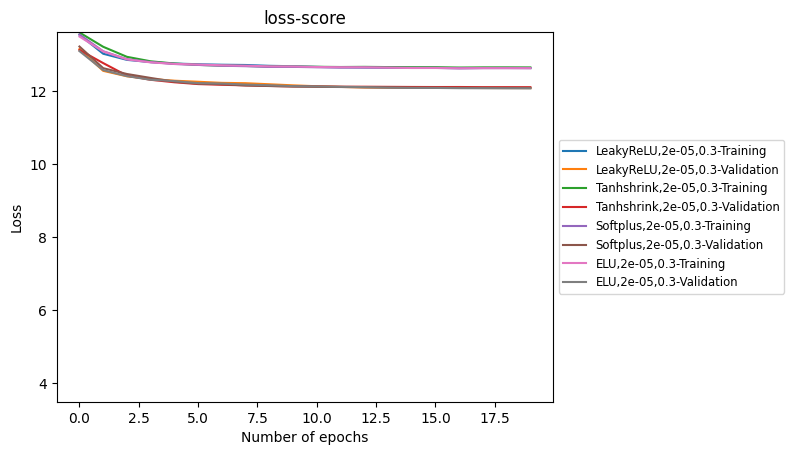

In [ ]:
plot_losses(list_entity_span_encoded_epochs, list_entity_training_losses, list_entity_validation_losses, activations, learning_rate, dropout_prob)